# Training a CNN Classifier

_(based on custom data)_

In [8]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os

In [9]:
import os
import cv2
import mediapipe as mp

import matplotlib.pyplot as plt

In [10]:
tf.__version__ 

'2.10.0'

### 1. Data Preprocessing

In [11]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [12]:
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

In [13]:
DATA_PATH = '../../Data/Hand-Gesture-data/asl_dataset'

In [14]:
data = []
labels = []
for dir_ in os.listdir(DATA_PATH):
    for img_path in os.listdir(os.path.join(DATA_PATH, dir_)):
        data_aux = []

        x_ = []
        y_ = []

        img = cv2.imread(os.path.join(DATA_PATH, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb) # type: ignore
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_.append(x)
                    y_.append(y)

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))
                    
            
            # Append data only if the expected number of landmarks is present
            if len(data_aux) == 42:  # 21 landmarks with x and y values (21*2=42)
                data.append(data_aux)  # Append as a full row of features
                labels.append(dir_)
            else:
                print(f"Skipping image {img_path} due to incomplete landmarks")

            # data.append(data_aux)
            # labels.append(dir_)


Skipping image hand1_0_bot_seg_2_cropped.jpeg due to incomplete landmarks
Skipping image hand1_0_bot_seg_5_cropped.jpeg due to incomplete landmarks
Skipping image hand2_8_right_seg_3_cropped.jpeg due to incomplete landmarks
Skipping image hand1_a_bot_seg_1_cropped.jpeg due to incomplete landmarks
Skipping image hand2_c_top_seg_1_cropped.jpeg due to incomplete landmarks
Skipping image hand1_d_bot_seg_4_cropped.jpeg due to incomplete landmarks
Skipping image hand1_d_dif_seg_1_cropped.jpeg due to incomplete landmarks
Skipping image hand1_d_dif_seg_2_cropped.jpeg due to incomplete landmarks
Skipping image hand3_m_dif_seg_2_cropped.jpeg due to incomplete landmarks
Skipping image hand2_q_top_seg_2_cropped.jpeg due to incomplete landmarks
Skipping image hand2_q_top_seg_3_cropped.jpeg due to incomplete landmarks


In [15]:
import numpy as np
data = np.array(data)  # Should be 2D (n_samples, n_features)
labels = np.array(labels)  # Should be 1D (n_samples,)

In [16]:
print("Data shape:", data.shape)  
print("Labels shape:", labels.shape)

Data shape: (1828, 42)
Labels shape: (1828,)


In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y, num_classes=36)
X = data

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(1462, 42)

In [20]:
y_train.shape

(1462, 36)

### 2. CNN Model creation

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [22]:
model = Sequential([
    Dense(64, input_shape=(42,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(36, activation='softmax')
])

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                2752      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 36)                612       
                                                                 
Total params: 5,972
Trainable params: 5,972
Non-trainable params: 0
_________________________________________________________________


### 3. Training and evaluating the CNN model

In [25]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
37/37 [==============================] - 1s 6ms/step - loss: 3.5274 - accuracy: 0.0522 - val_loss: 3.4859 - val_accuracy: 0.0512
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 3.4010 - accuracy: 0.0804 - val_loss: 3.3425 - val_accuracy: 0.0853
Epoch 3/50
37/37 [==============================] - 0s 2ms/step - loss: 3.2146 - accuracy: 0.1018 - val_loss: 3.1536 - val_accuracy: 0.0887
Epoch 4/50
37/37 [==============================] - 0s 2ms/step - loss: 3.0194 - accuracy: 0.1035 - val_loss: 2.9868 - val_accuracy: 0.1195
Epoch 5/50
37/37 [==============================] - 0s 2ms/step - loss: 2.8446 - accuracy: 0.1326 - val_loss: 2.8179 - val_accuracy: 0.1536
Epoch 6/50
37/37 [==============================] - 0s 2ms/step - loss: 2.6447 - accuracy: 0.1933 - val_loss: 2.6398 - val_accuracy: 0.1706
Epoch 7/50
37/37 [==============================] - 0s 3ms/step - loss: 2.4175 - accuracy: 0.2352 - val_loss: 2.4329 - val_accuracy: 0.2457
Epoch 8/50
37/37 [==

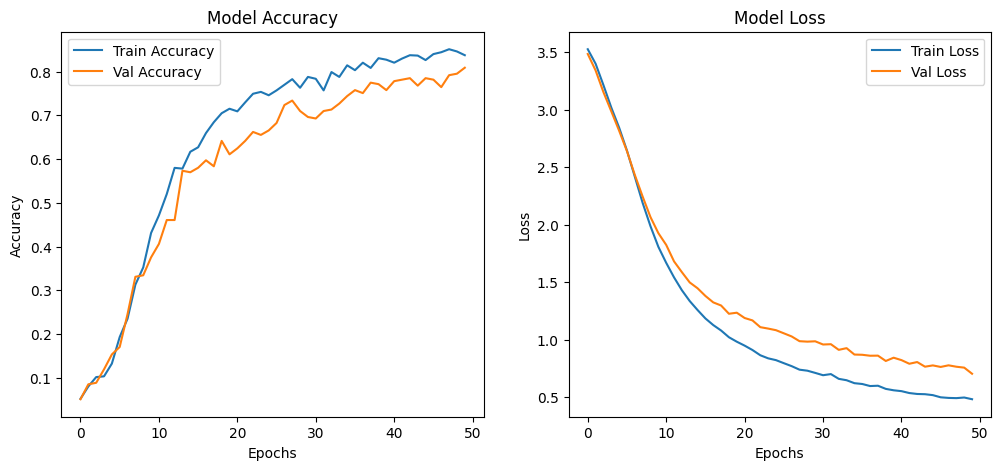

In [26]:
# Plotting the history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes))

12/12 [==============================] - 0s 1ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.17      0.50      0.25         4
           1       1.00      0.92      0.96        13
           2       0.57      0.50      0.53         8
           3       0.92      1.00      0.96        11
           4       0.89      1.00      0.94        17
           5       1.00      0.95      0.97        19
           6       0.69      0.60      0.64        15
           7       0.86      1.00      0.92        12
           8       1.00      0.88      0.94        17
           9       1.00      1.00      1.00        14
          10       0.75      1.00      0.86         3
          11       1.00      1.00      1.00         8
          12       0.50      0.86      0.63         7
          13       0.75      0.82      0.78        11
          14       0.71      1.00      0.83         5
          15       1.00      1.00      1.00        14
    

c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

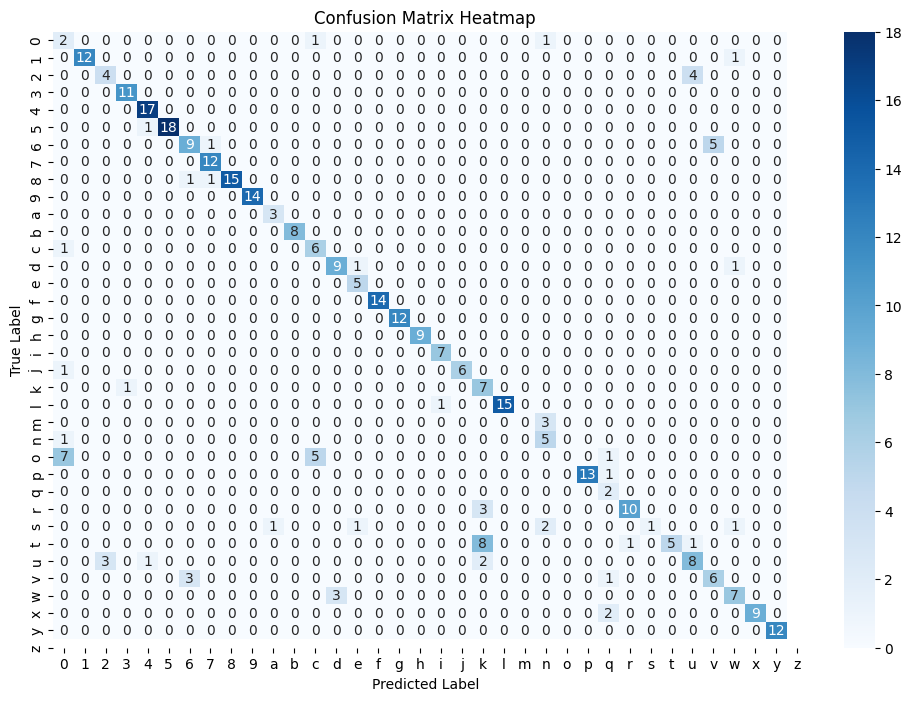

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 4. SAve the model

In [39]:
model_json = model.to_json()
with open("../../Models/HandGesture models/CNNmodel/model_cnn_v2.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
model.save_weights('../../Models/HandGesture models/CNNmodel/model_cnn_v2.h5')
print('Weights saved')

Model Saved
Weights saved
